In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import coursera_competition_udfs as udf
import gc

from sklearn.linear_model import LinearRegression

# Build panel data of monthly sales

Following the exercise from week 4,
- we aggregated sales data by month, and for each month creating a grid of only shops and items sold at all in that month (other combinations would add all zeroes to the data).
- we stack monthly time series data for all the relevant shop-item pairs. 
- Then we created lagged sales of the 3 types of sales data: previous monthly sales of the shop_item pair, and previous monthly sales of the shop, and item.

In [2]:
monthly_sales_grid = udf.create_all_monthly_sales_grid_with_lags(lags=None)

column added: target
column added: target_shop
column added: target_item


In [3]:
monthly_sales_grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 6 columns):
date_block_num    int64
item_id           int64
shop_id           int64
target            float64
target_item       float64
target_shop       float64
dtypes: float64(3), int64(3)
memory usage: 509.4 MB


# Construct trend and seasonality features

We observe (see chart below) that total sales have trend and seasonality. Since most time series methods are
based on stationary time series, we try to remove trend and seasonality before doing other modeling. This also helps disentangling general effects over the time period from other predictors.

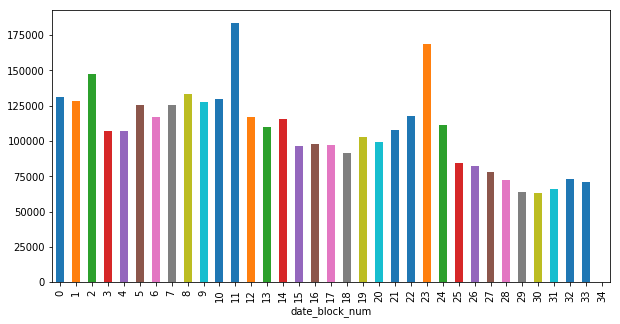

In [4]:
monthly_sales_grid.groupby('date_block_num')['target'].sum().plot(kind='bar', figsize=(10,5));

In [3]:
monthly_sales_grid = udf.add_seasonality_features(monthly_sales_grid)

In [4]:
monthly_sales_grid.head()

,date_block_num,item_id,shop_id,target,target_item,target_shop,month,december,quarters,Q1,Q4
0,0,22154,59,1.0,18.0,2017.0,1,False,Q1,True,False
1,0,2552,59,0.0,0.0,2017.0,1,False,Q1,True,False
2,0,2554,59,0.0,1.0,2017.0,1,False,Q1,True,False
3,0,2555,59,0.0,2.0,2017.0,1,False,Q1,True,False
4,0,2564,59,0.0,5.0,2017.0,1,False,Q1,True,False


# Fit deterministic trend and seasonality features

In [5]:
# splitting data by time
train_data, val_data = udf.train_test_split_by_month(monthly_sales_grid, 33)

Train data: date_block_num 0 to 32
Test data: date_block_num 33
target values in test data are clipped to [0, 20]
Train data size: (10675678, 11)
Test data size: (238172, 11)


/home/johanna/Dropbox/Code/Coursera_Kaggle_Project/coursera_competition_udfs.py:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_test[label] = df_test[label].clip(0, 20)


In [6]:
feature_cols = ['date_block_num', 'december', 'Q1', 'Q4']

X_train, y_train = train_data[feature_cols], train_data['target']
X_val, y_val = val_data[feature_cols], val_data['target']

In [7]:
model = LinearRegression().fit(X_train, y_train)
lr_result = udf.eval_model_pred(model, X_train, y_train, X_val, y_val)

       R-squared   RMSE
train      0.000  3.361
val       -0.005  1.139


In [8]:
lr_coef = pd.DataFrame({'features': X_train.columns, 'coef': lr_result.coef_})
lr_coef.append({'features': 'intercept', 'coef': lr_result.intercept_}, ignore_index=True)

,features,coef
0,date_block_num,-0.000760
1,december,0.139993
2,Q1,0.029303
3,Q4,0.041200
4,intercept,0.320340


In [17]:
import statsmodels.api as sm

In [44]:
# prep training data for OLS fitting
X_sm = X_train.copy()

X_sm['december'] = X_sm['december'].astype('int')
X_sm['Q1'] = X_sm['Q1'].astype('int')
X_sm['Q4'] = X_sm['Q4'].astype('int')

In [45]:
X_sm = sm.add_constant(X_sm)

In [46]:
X_sm.columns

Index(['const', 'date_block_num', 'december', 'Q1', 'Q4'], dtype='object')

In [48]:
model = sm.OLS(y_train.values, X_sm.values)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     484.4
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:56:47   Log-Likelihood:            -2.8091e+07
No. Observations:            10675678   AIC:                         5.618e+07
Df Residuals:                10675673   BIC:                         5.618e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3203      0.002    140.984      0.0

# Result and interpretation 

Summary of results:
- Fitting a linear model on a deterministic trend and seasonality features do not explain the data well, in particular OOS performance is terrible
- but the features are highly significant in sample, in particular the seasonality features.
- @MG: what does it mean that a linear regression finds highly significant variables but has an r-squared of zero?

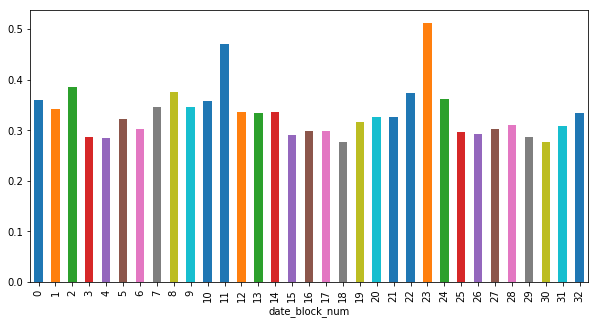

In [65]:
train_data.groupby('date_block_num')['target'].mean().plot(kind='bar', figsize=(10, 5))

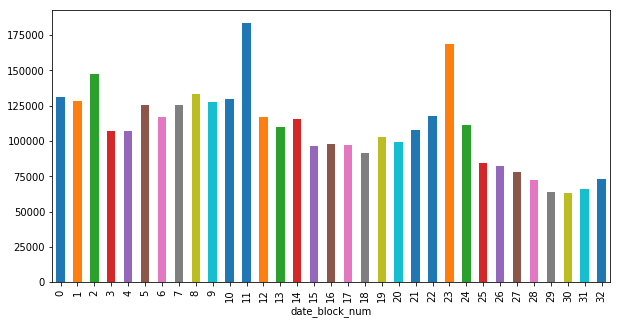

In [69]:
train_data.groupby('date_block_num')['target'].sum().plot(kind='bar', figsize=(10, 5))

The reason for why linear regression on trend and specific seasons performs so poorly could be due to a quirk in the data:
- while total sales follow trend and seasonality over time, average sales are much flatter over time, which is what lin reg picks up
- this is mostly driven by the number of shops in the data going down, allowing sales by shop on average to be constant over time
- and it comes from the way our sales data set is constructed: when a shops disappears in a given month, all the corresponding shop-item pairs also disappear from the grid in that month. i.e. the shops selling items do not stay constant over time, and there is significant survival bias in our monthly sales data.

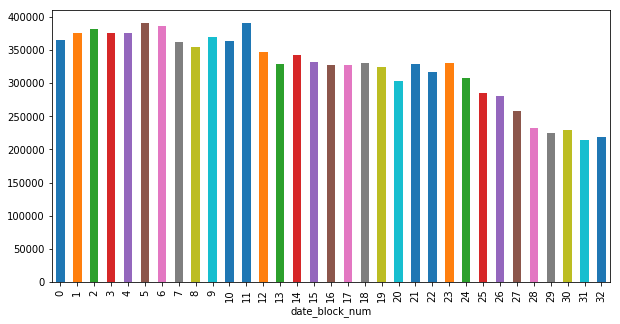

In [71]:
train_data.groupby('date_block_num')['shop_id'].count().plot(kind='bar', figsize=(10, 5))

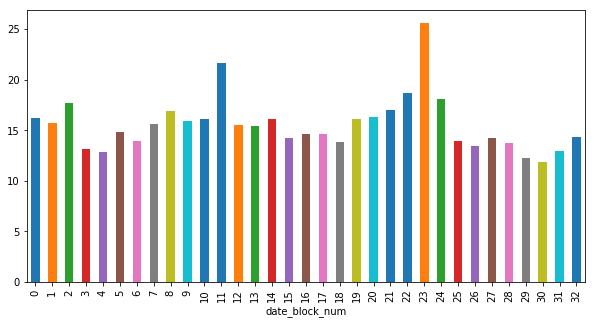

In [79]:
train_data.groupby('date_block_num')['target_item'].mean().plot(kind='bar', figsize=(10, 5))

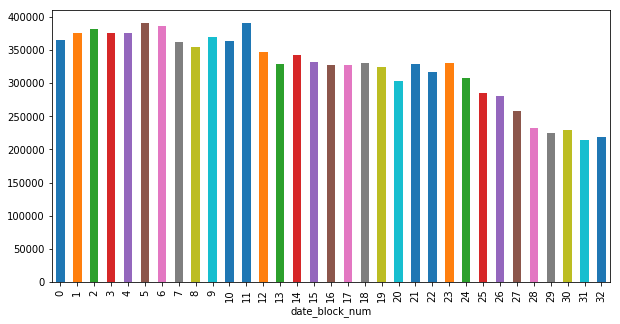

In [72]:
train_data.groupby('date_block_num')['item_id'].count().plot(kind='bar', figsize=(10, 5))

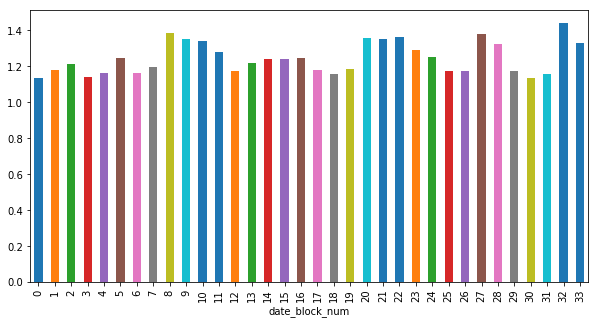

In [68]:
sales_train.groupby('date_block_num')['item_cnt_day'].mean().plot(kind='bar', figsize=(10, 5))

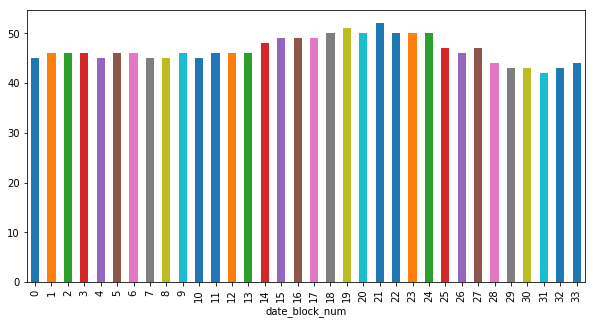

In [74]:
sales_train.groupby('date_block_num')['shop_id'].nunique().plot(kind='bar', figsize=(10, 5))

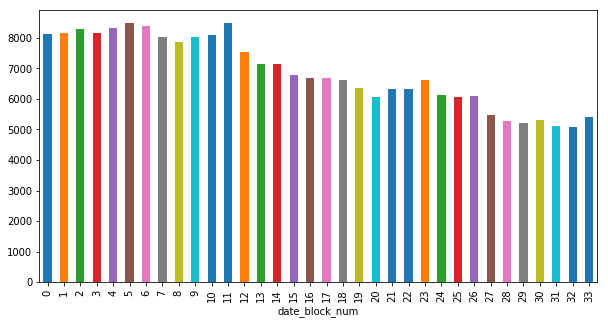

In [75]:
sales_train.groupby('date_block_num')['item_id'].nunique().plot(kind='bar', figsize=(10, 5))

Observations:
- total sales per month (across all shops and items) have gone down
- the number of shops opened is relatively flat
- the number of unique items sold has gone down
- among the items that did sell, the ratios of sales did not have a trend over time, though have seasonality

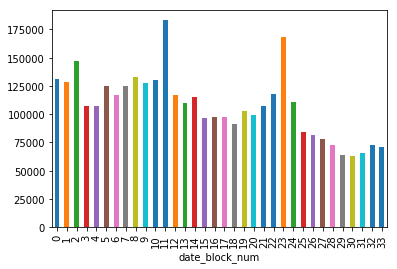

In [81]:
# total sales per month have gone down
sales_train.groupby(['date_block_num'])['item_cnt_day'].sum().plot(kind='bar')

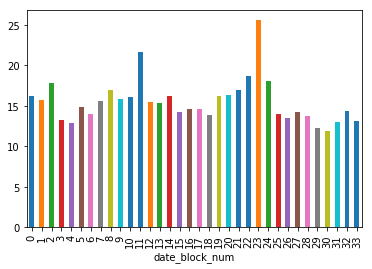

In [92]:
g_block = sales_train.groupby(['date_block_num'])
(g_block['item_cnt_day'].sum()/g_block['item_id'].nunique()).plot(kind='bar')

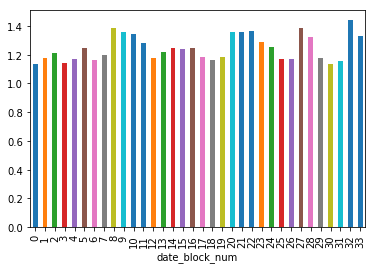

In [86]:
# total sales per month have gone down
sales_train.groupby(['date_block_num'])['item_cnt_day'].mean().plot(kind='bar')

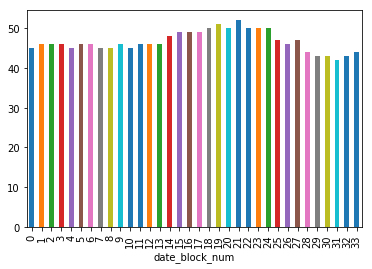

In [83]:
# total sales per month
sales_train.groupby(['date_block_num'])['shop_id'].nunique().plot(kind='bar')

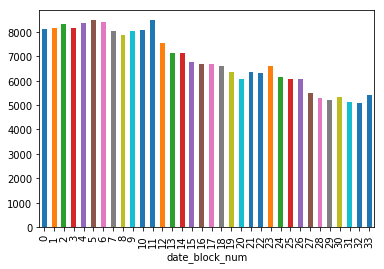

In [84]:
# total sales per month
sales_train.groupby(['date_block_num'])['item_id'].nunique().plot(kind='bar')

Conclusion:
- perhaps not fitting trend and seasonality beforehand, but considering the seasonality components as features in the full ML model